# Homework

> Note: sometimes your answer doesn't match one of 
> the options exactly. That's fine. 
> Select the option that's closest to your solution.


In this homework, we will use the lead scoring dataset Bank Marketing dataset. Download it from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv).


In this dataset our desired target for classification task will be `converted` variable - has the client signed up to the platform or not. 

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [1]:
data_url = "https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv"

In [3]:
df = pd.read_csv(data_url)

## Data preparation

* Check if the missing values are presented in the features.
* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0 


Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

Check if the missing values are presented in the features:

In [29]:
categorical = df.columns[df.dtypes == 'object'].to_list()
numerical = df.columns[df.dtypes != 'object'].to_list()
numerical.remove('converted')
df.isna().sum()

lead_source                 0
industry                    0
number_of_courses_viewed    0
annual_income               0
employment_status           0
location                    0
interaction_count           0
lead_score                  0
converted                   0
dtype: int64

* If there are missing values:
    * For caterogiral features, replace them with 'NA'
    * For numerical features, replace with with 0.0

In [13]:
df[categorical] = df[categorical].fillna("NA")
df[numerical] = df[numerical].fillna(0.0)

Split the data into 3 parts: train/validation/test with 60%/20%/20% distribution. Use `train_test_split` function for that with `random_state=1`

In [15]:
df

,lead_source,industry,number_of_courses_viewed,annual_income,employment_status,location,interaction_count,lead_score,converted
0,paid_ads,NA,1,79450.0,unemployed,south_america,4,0.94,1
1,social_media,retail,1,46992.0,employed,south_america,1,0.80,0
2,events,healthcare,5,78796.0,unemployed,australia,3,0.69,1
3,paid_ads,retail,2,83843.0,NA,australia,1,0.87,0
4,referral,education,3,85012.0,self_employed,europe,3,0.62,1
...,...,...,...,...,...,...,...,...,...
1457,referral,manufacturing,1,0.0,self_employed,north_america,4,0.53,1
1458,referral,technology,3,65259.0,student,europe,2,0.24,1
1459,paid_ads,technology,1,45688.0,student,north_america,3,0.02,1
1460,referral,NA,5,71016.0,self_employed,north_america,0,0.25,1


In [ ]:
from sklearn.model_selection import train_test_split

df_full_train, df_test = train_test_split(
    df,
    test_size=0.2,
    random_state=1,
)
df_train, df_val = train_test_split(
    df_full_train,
    test_size=0.25,
    random_state=1,
)

## Question 1: ROC AUC feature importance

ROC AUC could also be used to evaluate feature importance of numerical variables. 

Let's do that

* For each numerical variable, use it as score (aka prediction) and compute the AUC with the `y` variable as ground truth.
* Use the training dataset for that


If your AUC is < 0.5, invert this variable by putting "-" in front

(e.g. `-df_train['balance']`)

AUC can go below 0.5 if the variable is negatively correlated with the target variable. You can change the direction of the correlation by negating this variable - then negative correlation becomes positive.

Which numerical variable (among the following 4) has the highest AUC?

- `lead_score`
- `number_of_courses_viewed` [x]
- `interaction_count`
- `annual_income`

In [50]:
from sklearn.metrics import roc_auc_score

data = {
    'name': [],
    'score': []
}
for column in numerical:
    score = roc_auc_score(df_train.converted, df_train[column])
    if score < 0.5:
        score = roc_auc_score(df_train.converted, -df_train[column])
    data['name'].append(column)
    data['score'].append(score)

q1_df = pd.DataFrame(data)
q1_df.sort_values(by=['score'], ascending=False)

,name,score
0,number_of_courses_viewed,0.763568
2,interaction_count,0.738270
3,lead_score,0.614499
1,annual_income,0.551958


## Question 2: Training the model

Apply one-hot-encoding using `DictVectorizer` and train the logistic regression with these parameters:

```python
LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
```

What's the AUC of this model on the validation dataset? (round to 3 digits)

- 0.32
- 0.52
- 0.72 [x]
- 0.92

In [25]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [51]:
train_dicts = df_train[categorical + numerical].to_dict(orient='records')
val_dicts = df_val[categorical + numerical].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_dv_train = dv.fit_transform(train_dicts)
X_dv_val = dv.fit_transform(val_dicts)

model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
model.fit(X_dv_train, df_train.converted)
y_pred = model.predict(X_dv_val)
y_predict_proba =  model.predict_proba(X_dv_val)[:, 1]
roc_auc_score(y_pred, df_val.converted)

0.7617772108843538

## Question 3: Precision and Recall

Now let's compute precision and recall for our model.

* Evaluate the model on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?

* 0.145
* 0.345
* 0.545
* 0.745 [x]


In [54]:
from sklearn.metrics import precision_score, recall_score

thresholds = np.linspace(0, 1, 101)
rows = []

for thr in thresholds:
    y_hat = (y_predict_proba >= thr).astype(int)
        
    pr = precision_score(df_val.converted, y_hat, zero_division=0)
    rc = recall_score(df_val.converted, y_hat, zero_division=0)
    rows.append((thr, pr, rc))

grid_df = pd.DataFrame(rows, columns=['threshold', 'precision', 'recall'])
grid_df

,threshold,precision,recall
0,0.00,0.583618,1.000000
1,0.01,0.583618,1.000000
2,0.02,0.583618,1.000000
3,0.03,0.583618,1.000000
4,0.04,0.583618,1.000000
...,...,...,...
96,0.96,1.000000,0.017544
97,0.97,1.000000,0.005848
98,0.98,0.000000,0.000000
99,0.99,0.000000,0.000000


Found 1 intersection points:
  Threshold: 0.642, Precision: 0.779, Recall: 0.779


/var/folders/v0/8r5h4ym13fb_mzmqc1hfkt580000gn/T/ipykernel_65353/2302540193.py:19: RuntimeWarning: The iteration is not making good progress, as measured by the 
 improvement from the last ten iterations.
  root = fsolve(find_intersection, start_point)[0]


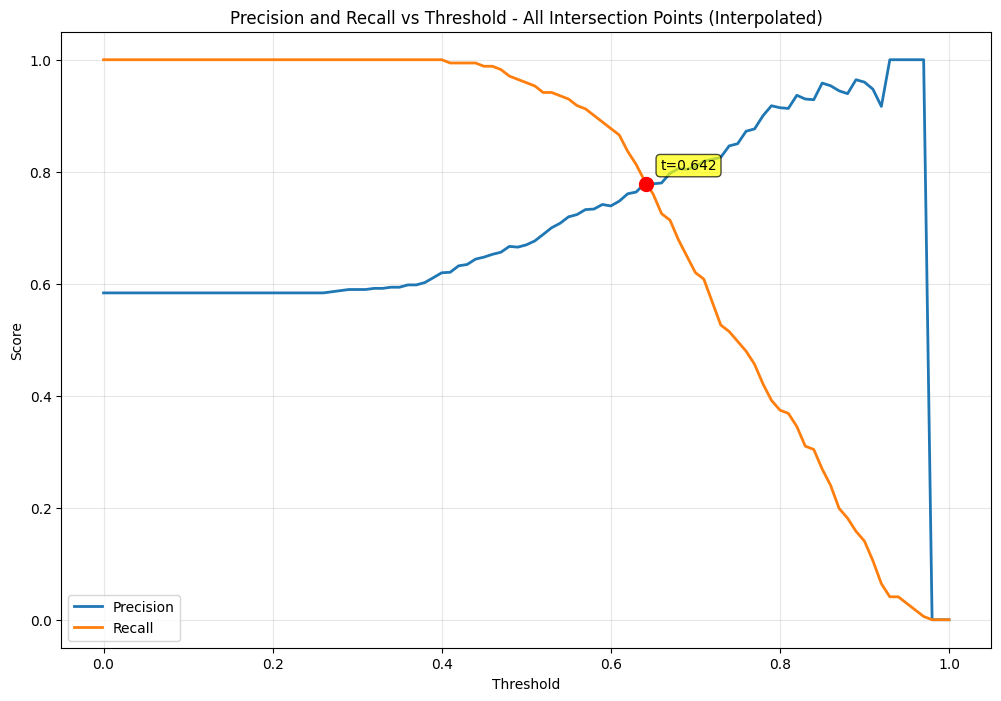

In [61]:
# Method 2: Use interpolation to find precise intersections
from scipy import interpolate
from scipy.optimize import fsolve

# Create interpolation functions
f_precision = interpolate.interp1d(grid_df.threshold, grid_df.precision, kind='linear')
f_recall = interpolate.interp1d(grid_df.threshold, grid_df.recall, kind='linear')

# Define function to find where precision == recall
def find_intersection(x):
    return f_precision(x) - f_recall(x)

# Find all intersections by solving f_precision(x) - f_recall(x) = 0
intersection_thresholds = []

# Try different starting points to find all intersections
for start_point in np.linspace(0, 1, 20):
    try:
        root = fsolve(find_intersection, start_point)[0]
        if 0 <= root <= 1:  # Make sure it's within our range
            intersection_thresholds.append(root)
    except:
        continue

# Remove duplicates and sort
intersection_thresholds = sorted(list(set([round(x, 3) for x in intersection_thresholds])))

print(f"Found {len(intersection_thresholds)} intersection points:")

# Plot with all intersection points
plt.figure(figsize=(12, 8))
plt.plot(grid_df.threshold, grid_df.precision, label='Precision', linewidth=2)
plt.plot(grid_df.threshold, grid_df.recall, label='Recall', linewidth=2)

for threshold in intersection_thresholds:
    precision = f_precision(threshold)
    recall = f_recall(threshold)
    
    plt.scatter(threshold, precision, 
               color='red', s=100, zorder=5)
    
    plt.annotate(f't={threshold:.3f}', 
                (threshold, precision), 
                xytext=(10, 10), 
                textcoords='offset points',
                fontsize=10,
                bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    print(f"  Threshold: {threshold:.3f}, Precision: {precision:.3f}, Recall: {recall:.3f}")

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold - All Intersection Points (Interpolated)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [59]:
grid_df['diff'].idxmin()

98

## Question 4: F1 score

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing F1:

$$F_1 = 2 \cdot \cfrac{P \cdot R}{P + R}$$

Where $P$ is precision and $R$ is recall.

Let's compute F1 for all thresholds from 0.0 to 1.0 with increment 0.01

At which threshold F1 is maximal?

- 0.14
- 0.34
- 0.54 [x]
- 0.74

In [62]:
from sklearn.metrics import f1_score
eps = 1e-6
rows = []

for thr in thresholds:
    y_hat = (y_predict_proba >= thr).astype(int)
        
    pr = precision_score(df_val.converted, y_hat, zero_division=0)
    rc = recall_score(df_val.converted, y_hat, zero_division=0)
    # f1 = 2 * ((pr * rc) / (pr + rc + eps))
    f1 = f1_score(df_val.converted, y_hat, zero_division=0)
    rows.append((thr, pr, rc, f1))

f1_df = pd.DataFrame(rows, columns=['threshold', 'precision', 'recall', 'f1'])

In [63]:
f1_df.sort_values(by=['f1'], ascending=False)

,threshold,precision,recall,f1
57,0.57,0.732394,0.912281,0.812500
55,0.55,0.719457,0.929825,0.811224
56,0.56,0.723502,0.918129,0.809278
59,0.59,0.741463,0.888889,0.808511
58,0.58,0.733333,0.900585,0.808399
...,...,...,...,...
96,0.96,1.000000,0.017544,0.034483
97,0.97,1.000000,0.005848,0.011628
98,0.98,0.000000,0.000000,0.000000
99,0.99,0.000000,0.000000,0.000000


## Question 5: 5-Fold CV


Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

```
KFold(n_splits=5, shuffle=True, random_state=1)
```

* Iterate over different folds of `df_full_train`
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard deviation of the scores across different folds?

- 0.0001
- 0.006
- 0.06 [x]
- 0.36

In [70]:
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)
scores = []
for train_idx, val_idx in kfold.split(df_full_train):
    df_train_kfold = df_full_train.iloc[train_idx]
    df_val_kfold = df_full_train.iloc[val_idx]

    train_dicts_kfold = df_train_kfold[numerical + categorical].to_dict(orient='records')
    val_dicts_kfold = df_val_kfold[numerical + categorical].to_dict(orient='records')

    X_dv_train = dv.fit_transform(train_dicts_kfold)
    X_dv_val = dv.transform(val_dicts_kfold)

    y_train_kfold = df_train_kfold.converted.values
    y_val_kfold = df_val_kfold.converted.values
    model_kfold = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
    model_kfold.fit(X_dv_train, y_train_kfold)
    y_pred_kfold = model_kfold.predict(X_dv_val)

    auc_ = roc_auc_score(y_val_kfold, y_pred_kfold)
    scores.append(auc_)

print('%.3f +- %.3f' % (np.mean(scores), np.std(scores)))

0.664 +- 0.025


## Question 6: Hyperparameter Tuning

Now let's use 5-Fold cross-validation to find the best parameter `C`

* Iterate over the following `C` values: `[0.000001, 0.001, 1]`
* Initialize `KFold` with the same parameters as previously
* Use these parameters for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which `C` leads to the best mean score?

- 0.000001
- 0.001
- 1 [x]

If you have ties, select the score with the lowest std. If you still have ties, select the smallest `C`.

In [72]:
rows = []
for c_param in [0.000001, 0.001, 1]:
    kfold = KFold(n_splits=5, shuffle=True, random_state=1)
    scores = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train_kfold = df_full_train.iloc[train_idx]
        df_val_kfold = df_full_train.iloc[val_idx]

        train_dicts_kfold = df_train_kfold[numerical + categorical].to_dict(orient='records')
        val_dicts_kfold = df_val_kfold[numerical + categorical].to_dict(orient='records')

        X_dv_train = dv.fit_transform(train_dicts_kfold)
        X_dv_val = dv.transform(val_dicts_kfold)

        y_train_kfold = df_train_kfold.converted.values
        y_val_kfold = df_val_kfold.converted.values
        model_kfold = LogisticRegression(solver='liblinear', C=c_param, max_iter=1000, random_state=1)
        model_kfold.fit(X_dv_train, y_train_kfold)
        y_pred_kfold = model_kfold.predict(X_dv_val)

        auc_ = roc_auc_score(y_val_kfold, y_pred_kfold)
        scores.append(auc_)

    rows.append((c_param, np.mean(scores), np.std(scores)))

c_scores_df = pd.DataFrame(rows, columns=['C_score', 'mean', 'std'])
    

In [ ]:
c_scores_df.sort_values(by=['mean'], ascending=False)

,C_score,mean,std
2,1.000000,0.663743,0.024815
1,0.001000,0.508858,0.005746
0,0.000001,0.501136,0.002273
